In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
def scatter_plot(x_: np.ndarray, 
                 y_: np.ndarray, 
                 name_x: str, 
                 name_y: str,
                 ax=None):
    """
    scatter plot
    """
    data = pd.DataFrame(np.concatenate([x_, y_], axis=1), 
                    columns=[name_x, name_y])
    if ax is None:
        sns.jointplot(data=data, x=name_x, y=name_y, kind="reg")
    else:
        sns.jointplot(data=data, x=name_x, y=name_y, kind="reg", ax=ax)

In [3]:
def simulate_data(sample_size: int, 
                 number_features: int,
                 noise_size: float,
                 eigenvalues: np.ndarray,
                 bstar) -> tuple:
    """
    now we simulate data 

    """
    T = sample_size # sample size
    P = number_features  # number of features (signals or predictors)
    sigma = noise_size # size of noise 
    noise = np.random.randn(T, 1) * sigma # noise 
    
    signals = np.random.randn(T, P) 
    signals =  signals @ np.diag(eigenvalues.flatten() ** 0.5, 0)
    betas = np.random.randn(P, 1) * np.sqrt(bstar / P)
    infeasible_predictions = signals @ betas 
    labels = infeasible_predictions + noise
    
    return (labels, infeasible_predictions, signals, betas)

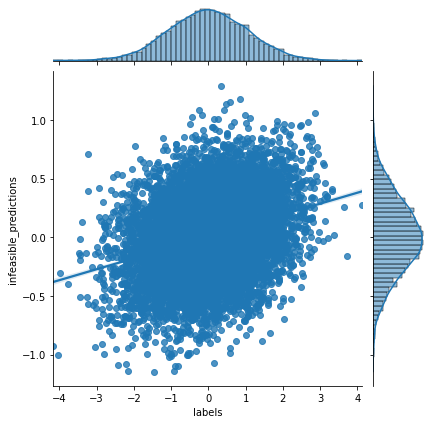

In [4]:
sample_size = 10000
number_features = 2000
noise_size = 1.
eigenvalues = 1. + np.zeros([1, number_features]) # eigenvalues of the covariance matrix of signals 
magnitude_of_betas = 0.1
(labels, infeasible_predictions, signals, betas) = simulate_data(sample_size,
                                                                 number_features,
                                                                 noise_size,
                                                                 eigenvalues,
                                                                 bstar=magnitude_of_betas)

scatter_plot(labels, 
             infeasible_predictions, 
             'labels', 
             'infeasible_predictions')

In [5]:
def performance_metrics_of_regression(labels: np.ndarray, 
                                      predictions: np.ndarray) -> tuple: 
    """
    Compute standard performance metrics for regression: mse and Rsquared 
    """
    mse = ((predictions - labels) ** 2).mean()
    r2 = 1 - mse / (labels ** 2).mean()
    print(f'r2 = {"%.2f" % r2}, mse = {"%.2f" % mse}')
    
    return mse, r2

In [6]:
mse, r2 = performance_metrics_of_regression(labels, infeasible_predictions)

r2 = 0.09, mse = 1.00


In [7]:
print(f'by the law of large numbers, it must be that {mse} approximately equals {noise_size ** 2}')

by the law of large numbers, it must be that 1.003991038348162 approximately equals 1.0


In [8]:
signal_covariance_matrix = signals.T @ signals / sample_size
print(f'by the law of large numbers, it must be that '
      f'{np.trace(signal_covariance_matrix) / number_features} approximately equals {eigenvalues.mean()}')

by the law of large numbers, it must be that 0.9999905483795923 approximately equals 1.0


In [9]:
betas.T @ betas

array([[0.10373]])

In [10]:
contribution_of_signals = betas.T @ (signal_covariance_matrix @ betas)
theoretical_value = magnitude_of_betas * np.trace(signal_covariance_matrix) / number_features
print(f'by the law of large numbers, it must be that {theoretical_value}' 
      f' approximately equals {contribution_of_signals}')

by the law of large numbers, it must be that 0.09999905483795925 approximately equals [[0.1050843]]


In [11]:
ideal_rsquared = contribution_of_signals / (labels ** 2).mean()
print(f'{r2} should be approximately {ideal_rsquared} by the law of large numbers')

0.09135494247235454 should be approximately [[0.09510477]] by the law of large numbers


In [12]:
def naive_ridge_regression(labels, features, penalty):
    """
    Simple, naive ridge regression
    """
    means = features.T @ labels / features.shape[0]
    feature_covariance = features.T @ features / features.shape[0] + penalty * np.eye(features.shape[1])
    inverse_covariance = np.linalg.inv(feature_covariance)
    beta_estimate = inverse_covariance @ means
    return beta_estimate

In [13]:
# NOW WE START DOING THE TRUE STUFF: TRAIN AND TEST SAMPLE SPLIT 
split = int(sample_size / 2)
ridge_penalty = 0.00001

train_labels = labels[:split]
test_labels = labels[split:]

beta_estimate_using_train_sample = naive_ridge_regression(train_labels, 
                                                          features=signals[:split, :], 
                                                          penalty=ridge_penalty)
predictions_based_on_train_sample_betas = signals @ beta_estimate_using_train_sample
performance_metrics_of_regression(test_labels, 
                                  predictions_based_on_train_sample_betas[split:])

r2 = -0.52, mse = 1.67


(1.6711235996162035, -0.521263373286607)

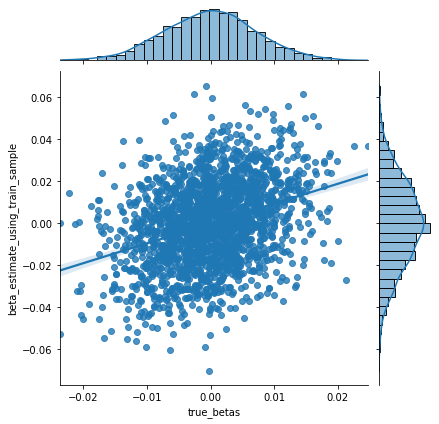

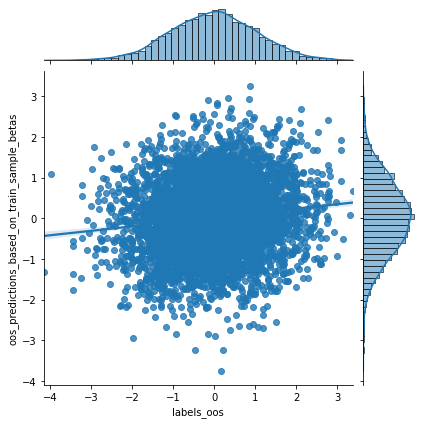

In [14]:
scatter_plot(betas, 
             beta_estimate_using_train_sample, 
             'true_betas', 
             'beta_estimate_using_train_sample',
              ax=None)


scatter_plot(labels[split:], 
             predictions_based_on_train_sample_betas[split:], 
             'labels_oos', 
             'oos_predictions_based_on_train_sample_betas',
              ax=None)

In [15]:
def marcenko_pastur_distribution(grid: np.ndarray, 
                                 complexity: float, 
                                 signal_variance: float) -> np.ndarray:
    """
    Eigenvalue distribution according to the Marcenko-Pastur Theorem 
    """
    lambda_plus = (signal_variance ** 2) * ((1 + np.sqrt(complexity)) ** 2)
    lambda_minus = (signal_variance ** 2) * ((1 - np.sqrt(complexity)) ** 2)
    
    tmp = (lambda_plus - grid) * (grid - lambda_minus)
    tmp = tmp * (tmp > 0)
    
    return (1 / (2 * math.pi * (signal_variance ** 2))) * np.sqrt(tmp) / (complexity * grid)

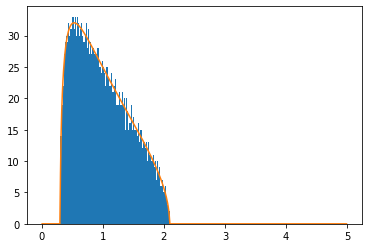

In [16]:
###################################################
# NOW WE START INVESTIGATING THE BEHAVIOUR OF EIGENVALUES 

signal_covariance = signals.T @ signals / signals.shape[0]
empirical_eigenvalues = np.linalg.eigh(signal_covariance)[0]
empirical_eigenvalues = empirical_eigenvalues[empirical_eigenvalues > 10 ** (-15)] 
grid = np.arange(0.01, 5, 0.01)
fig, ax = plt.subplots()
ax.hist(empirical_eigenvalues, bins=100)
mp_distribution = marcenko_pastur_distribution(grid, 
                                             complexity=number_features / sample_size, 
                                             signal_variance=1.)
factor = 0.018
mp_distribution = factor * mp_distribution * number_features
ax.plot(grid, mp_distribution)

In [17]:
def marcenko_pastur_trace_of_the_resolvent(complexity: float, 
                                           grid_of_z: np.ndarray) -> np.ndarray:
    """
    trace((zI+\hat\Psi)^{-1}) / P according to the Marcenko-Pastur Theorem
    (zI+\hat\Psi)^{-1} is called the RESOLVENT 
    """
    tmp = 2 / (np.sqrt((1 - complexity + grid_of_z) ** 2 + 4 * complexity * grid_of_z) 
               + (1 - complexity + grid_of_z))
    return tmp

Text(0.5, 1.0, 'complexity=0.2')

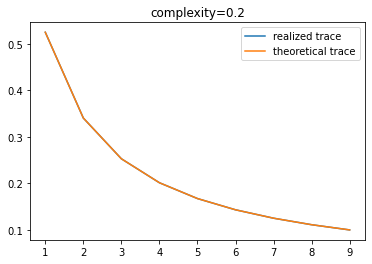

In [18]:
grid_of_z = np.arange(1, 10)
eigenvalues, eigenvectors = np.linalg.eigh(signal_covariance)
# trace((zI+\hat\Psi)^{-1}) / P = \sum_i (lambda(i)+z)^{-1} / P

traces_of_resolvent = np.sum((eigenvalues.reshape(-1, 1) 
                              + grid_of_z.reshape(1, -1)) ** (- 1), axis=0) / number_features
complexity = number_features / sample_size
theoretical_traces_of_resolvent = marcenko_pastur_trace_of_the_resolvent(complexity, 
                                                                        grid_of_z)
merged = pd.DataFrame(np.concatenate([traces_of_resolvent.reshape(-1, 1), 
                                      theoretical_traces_of_resolvent.reshape(-1, 1)], 
                                     axis=1))
merged.index = grid_of_z
merged.columns = ['realized trace', 'theoretical trace']
merged.plot()
plt.title(f'complexity={complexity}')

Text(0.5, 1.0, 'sharpe ratio = 0.5')

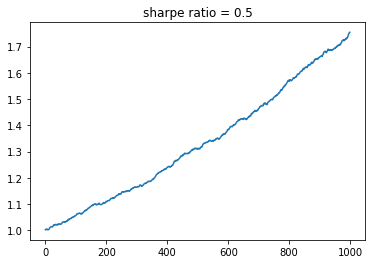

In [19]:
# we now build the objects from the theory 
mu = 0.5
returns = np.random.randn(1000, 1) + mu
plt.plot(np.cumprod(1 + 0.001 * returns))
plt.title(f'sharpe ratio = {mu / 1}')

In [33]:
# AND NOW WE START WORKING WITH REAL DATA 
import os
data_folder = '/Users/malamud/Dropbox/MY_STUFF/TEACHING/DataDrivenBusinessAnalytics/'
goyal_welch_data = pd.read_csv(os.path.join(data_folder,'PredictorData2021.csv'), index_col=0)
goyal_welch_data.index = pd.to_datetime(goyal_welch_data.index, format='%Y%m')

for column in goyal_welch_data.columns:
    goyal_welch_data[column] = [float(str(x).replace(',', '')) for x in goyal_welch_data[column]]


<AxesSubplot:xlabel='yyyymm'>

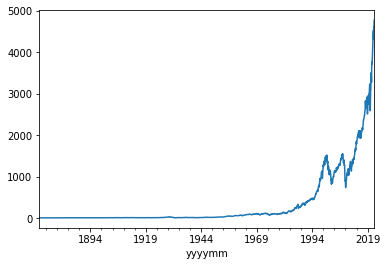

In [34]:
goyal_welch_data['Index'].plot()

<AxesSubplot:xlabel='yyyymm'>

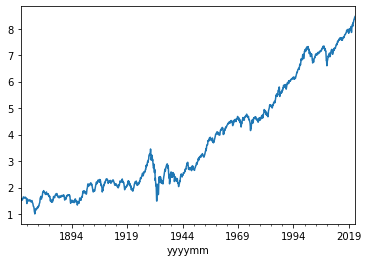

In [35]:
np.log(goyal_welch_data['Index']).plot()

In [36]:
goyal_welch_data.columns

Index(['Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis',
       'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx'],
      dtype='object')

<AxesSubplot:xlabel='yyyymm'>

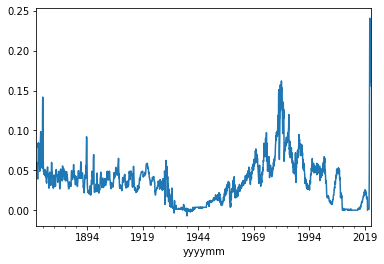

In [37]:
(12 * goyal_welch_data.Rfree).plot()

In [38]:
goyal_welch_data.tail(20)


,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
yyyymm,,,,,,,,,,,,,,,,,
2020-05-01,3044.31,59.6491,104.9300,0.264301,0.0013,0.0250,0.0395,0.0067,-0.014967,0.000100,0.000020,-0.0097,0.0084,0.004072,NaN,0.047818,0.045587
2020-06-01,3100.29,59.6834,99.2300,0.259900,0.0016,0.0244,0.0364,0.0073,-0.016845,0.000100,0.005472,0.0023,0.0146,0.007209,NaN,0.020348,0.018885
2020-07-01,3271.12,59.4060,98.8933,0.253848,0.0013,0.0214,0.0331,0.0062,-0.011998,0.000100,0.005058,0.0287,0.0610,0.001608,NaN,0.056910,0.055682
2020-08-01,3500.31,59.1286,98.5567,0.235975,0.0010,0.0225,0.0327,0.0065,-0.008504,0.000100,0.003153,-0.0349,-0.0488,0.000743,NaN,0.072068,0.070308
2020-09-01,3363.00,58.8512,98.2200,0.241482,0.0011,0.0231,0.0336,0.0068,-0.005698,0.000100,0.001393,0.0080,0.0041,0.004907,NaN,-0.038151,-0.039366
2020-10-01,3269.96,58.6604,96.8567,0.253146,0.0010,0.0235,0.0344,0.0079,-0.001895,0.000100,0.000415,-0.0238,-0.0190,0.003661,NaN,-0.026409,-0.027507
2020-11-01,3621.63,58.4696,95.4933,0.226352,0.0009,0.0230,0.0330,0.0087,-0.005262,0.000100,-0.000611,0.0093,0.0509,0.002492,NaN,0.109404,0.107624
2020-12-01,3756.07,58.2788,94.1300,0.219195,0.0009,0.0226,0.0316,0.0093,-0.000098,0.000100,0.000941,-0.0115,0.0000,0.000678,NaN,0.041572,0.040137
2021-01-01,3714.24,58.0637,105.4867,0.223756,0.0008,0.0245,0.0324,0.0108,0.002697,0.002697,0.004254,-0.0304,-0.0331,0.002078,NaN,-0.010052,-0.011090


In [39]:
# a glitch in the data 
goyal_welch_data.Rfree.iloc[-12:] = goyal_welch_data.Rfree.iloc[-12:] / 12

In [40]:
goyal_welch_data['returns'] = (goyal_welch_data.Index / goyal_welch_data.Index.shift(1) - 1).fillna(0)

In [41]:
goyal_welch_data['returns'].describe()


count    1812.000000
mean        0.004970
std         0.047164
min        -0.299423
25%        -0.018837
50%         0.006232
75%         0.031413
max         0.422222
Name: returns, dtype: float64

In [42]:
goyal_welch_data.Rfree.describe()


count    1811.000000
mean        0.002943
std         0.002135
min        -0.000600
25%         0.001400
50%         0.002900
75%         0.004000
max         0.013500
Name: Rfree, dtype: float64

Text(0.5, 1.0, 'leverage = 2')

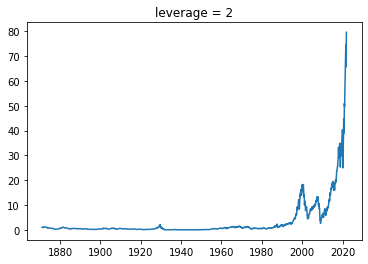

In [43]:
goyal_welch_data['excess_returns'] = goyal_welch_data.returns - goyal_welch_data.Rfree
leverage = 2
strategy_returns = goyal_welch_data.Rfree + leverage * goyal_welch_data.excess_returns
plt.plot(np.cumprod(1 + strategy_returns))
plt.title(f'leverage = {leverage}')

In [44]:
goyal_welch_data.columns

Index(['Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis',
       'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx', 'returns', 'excess_returns'],
      dtype='object')

<AxesSubplot:xlabel='yyyymm'>

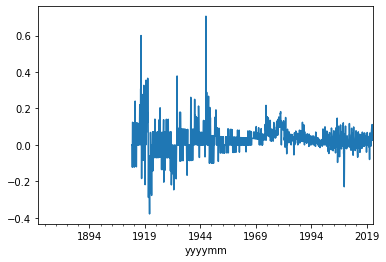

In [45]:
(12 * goyal_welch_data.infl).plot()

In [46]:
goyal_welch_data.infl.describe()


count    1307.000000
mean        0.002586
std         0.006435
min        -0.031579
25%         0.000000
50%         0.002404
75%         0.005464
max         0.058824
Name: infl, dtype: float64

In [47]:
goyal_welch_data.tail(20)



,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx,returns,excess_returns
yyyymm,,,,,,,,,,,,,,,,,,,
2020-05-01,3044.31,59.6491,104.9300,0.264301,0.0013,0.0250,0.0395,0.0067,-0.014967,0.000100,0.000020,-0.0097,0.0084,0.004072,NaN,0.047818,0.045587,0.045282,0.045182
2020-06-01,3100.29,59.6834,99.2300,0.259900,0.0016,0.0244,0.0364,0.0073,-0.016845,0.000100,0.005472,0.0023,0.0146,0.007209,NaN,0.020348,0.018885,0.018388,0.018288
2020-07-01,3271.12,59.4060,98.8933,0.253848,0.0013,0.0214,0.0331,0.0062,-0.011998,0.000100,0.005058,0.0287,0.0610,0.001608,NaN,0.056910,0.055682,0.055101,0.055001
2020-08-01,3500.31,59.1286,98.5567,0.235975,0.0010,0.0225,0.0327,0.0065,-0.008504,0.000100,0.003153,-0.0349,-0.0488,0.000743,NaN,0.072068,0.070308,0.070065,0.069965
2020-09-01,3363.00,58.8512,98.2200,0.241482,0.0011,0.0231,0.0336,0.0068,-0.005698,0.000100,0.001393,0.0080,0.0041,0.004907,NaN,-0.038151,-0.039366,-0.039228,-0.039328
2020-10-01,3269.96,58.6604,96.8567,0.253146,0.0010,0.0235,0.0344,0.0079,-0.001895,0.000100,0.000415,-0.0238,-0.0190,0.003661,NaN,-0.026409,-0.027507,-0.027666,-0.027766
2020-11-01,3621.63,58.4696,95.4933,0.226352,0.0009,0.0230,0.0330,0.0087,-0.005262,0.000100,-0.000611,0.0093,0.0509,0.002492,NaN,0.109404,0.107624,0.107546,0.107446
2020-12-01,3756.07,58.2788,94.1300,0.219195,0.0009,0.0226,0.0316,0.0093,-0.000098,0.000100,0.000941,-0.0115,0.0000,0.000678,NaN,0.041572,0.040137,0.037121,0.037021
2021-01-01,3714.24,58.0637,105.4867,0.223756,0.0008,0.0245,0.0324,0.0108,0.002697,0.000225,0.004254,-0.0304,-0.0331,0.002078,NaN,-0.010052,-0.011090,-0.011137,-0.011361


In [48]:
goyal_welch_data.corr()

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx,returns,excess_returns
Index,1.000000,0.975579,0.966720,-0.588241,-0.234832,-0.139113,-0.177995,-0.205581,-0.388060,-0.231202,-0.029418,0.012449,0.022497,0.010062,-0.394410,0.022956,0.038479,0.047838,0.058127
D12,0.975579,1.000000,0.966228,-0.563008,-0.193197,-0.073746,-0.111140,-0.140868,-0.449075,-0.204022,-0.031308,0.032103,0.039046,0.029700,-0.591115,0.011188,0.026269,0.038884,0.047966
E12,0.966720,0.966228,1.000000,-0.551382,-0.180009,-0.083851,-0.130030,-0.143793,-0.412112,-0.189336,-0.019237,0.035772,0.030075,-0.010686,-0.520702,0.014255,0.029347,0.041111,0.049525
b/m,-0.588241,-0.563008,-0.551382,1.000000,0.200183,0.154424,0.253283,0.190032,0.027363,0.184662,0.081415,-0.003625,-0.015082,0.173262,0.273217,-0.053911,-0.073167,-0.076964,-0.085352
tbl,-0.234832,-0.193197,-0.180009,0.200183,1.000000,0.888335,0.828012,0.901870,0.030187,0.986823,0.209338,0.047723,0.025233,-0.150610,-0.583011,-0.022605,-0.023194,-0.028550,-0.074051
AAA,-0.139113,-0.073746,-0.083851,0.154424,0.888335,1.000000,0.970365,0.988241,-0.087579,0.879230,0.164955,0.100032,0.096124,-0.045728,-0.650444,-0.012925,-0.011034,-0.014698,-0.055192
BAA,-0.177995,-0.111140,-0.130030,0.253283,0.828012,0.970365,1.000000,0.944503,-0.124661,0.821581,0.099799,0.110977,0.112208,0.076060,-0.601867,-0.015458,-0.015373,-0.019971,-0.057797
lty,-0.205581,-0.140868,-0.143793,0.190032,0.901870,0.988241,0.944503,1.000000,-0.068151,0.887952,0.191304,0.047854,0.046208,-0.097916,-0.657265,-0.014806,-0.014014,-0.018019,-0.058908
ntis,-0.388060,-0.449075,-0.412112,0.027363,0.030187,-0.087579,-0.124661,-0.068151,1.000000,0.028831,-0.053625,-0.056433,-0.050302,-0.036282,0.248873,-0.072462,-0.077060,-0.073959,-0.075158
Rfree,-0.231202,-0.204022,-0.189336,0.184662,0.986823,0.879230,0.821581,0.887952,0.028831,1.000000,0.187178,0.083444,0.058267,-0.122346,-0.587353,-0.018923,-0.018593,-0.034405,-0.079457


In [49]:
goyal_welch_data.dropna()

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx,returns,excess_returns
yyyymm,,,,,,,,,,,,,,,,,,,
1937-05-01,16.26,0.8100,1.1500,0.489382,0.0041,0.0333,0.0484,0.0282,0.028278,0.0006,0.006993,0.0053,0.0040,0.003593,0.003398,-0.005699,-0.011686,-0.010347,-0.010947
1937-06-01,15.40,0.8400,1.1700,0.504961,0.0036,0.0328,0.0493,0.0285,0.031266,0.0003,0.000000,-0.0018,0.0053,0.002984,0.004206,-0.053803,-0.057853,-0.052891,-0.053191
1937-07-01,16.98,0.8167,1.1867,0.464649,0.0028,0.0325,0.0491,0.0277,0.027225,0.0003,0.006944,0.0138,0.0039,0.002982,0.003630,0.098991,0.098012,0.102597,0.102297
1937-08-01,16.04,0.7933,1.2033,0.481935,0.0029,0.0324,0.0492,0.0286,0.031064,0.0002,0.000000,-0.0104,-0.0017,0.002141,0.003325,-0.051183,-0.056291,-0.055359,-0.055559
1937-09-01,13.76,0.7700,1.2200,0.553147,0.0031,0.0328,0.0516,0.0284,0.035847,0.0004,0.006897,0.0045,0.0025,0.015821,0.003339,-0.139610,-0.143683,-0.142145,-0.142545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-08-01,916.07,15.8790,28.9400,0.284412,0.0162,0.0637,0.0758,0.0510,0.024748,0.0014,0.003331,0.0464,0.0452,0.009409,-0.002908,0.007061,0.005401,0.004881,0.003481
2002-09-01,815.29,15.7990,30.0400,0.324555,0.0163,0.0615,0.0740,0.0480,0.029299,0.0014,0.001660,0.0417,0.0330,0.007366,-0.003213,-0.108965,-0.110421,-0.110013,-0.111413
2002-10-01,885.76,15.8907,29.2233,0.293437,0.0158,0.0632,0.0773,0.0508,0.025671,0.0014,0.001657,-0.0294,-0.0240,0.011590,-0.003753,0.088599,0.087103,0.086436,0.085036


In [50]:
goyal_welch_data


,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx,returns,excess_returns
yyyymm,,,,,,,,,,,,,,,,,,,
1871-01-01,4.44,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1871-02-01,4.50,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013514,0.008547
1871-03-01,4.61,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024444,0.019919
1871-04-01,4.74,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028200,0.023948
1871-05-01,4.86,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,0.004643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025316,0.020673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,4522.68,58.7913,169.8333,0.184756,0.0005,0.0255,0.0324,0.0128,0.014846,0.001237,0.002066,-0.0035,-0.0045,0.000602,NaN,0.030600,0.029205,0.028990,0.027753
2021-09-01,4307.54,59.2545,175.3700,0.193036,0.0004,0.0253,0.0323,0.0137,0.015598,0.001300,0.002716,-0.0250,-0.0194,0.001393,NaN,-0.046076,-0.047152,-0.047569,-0.048869
2021-10-01,4605.38,59.6354,182.8600,0.182389,0.0005,0.0268,0.0335,0.0158,0.013368,0.001114,0.008308,0.0051,0.0159,0.001151,NaN,0.070510,0.069627,0.069144,0.068030


In [51]:
cleaned_data = goyal_welch_data.loc['1975':].drop(columns=['csp']).fillna(0)

In [52]:
cleaned_data

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,CRSP_SPvw,CRSP_SPvwx,returns,excess_returns
yyyymm,,,,,,,,,,,,,,,,,,
1975-01-01,76.98,3.6233,8.7433,0.980830,0.0626,0.0883,0.1081,0.0796,0.008510,0.005800,0.003854,0.0225,0.0596,0.004017,0.123610,0.121698,0.122812,0.117012
1975-02-01,81.59,3.6467,8.5967,0.933902,0.0550,0.0862,0.1065,0.0788,0.011652,0.004300,0.007678,0.0131,0.0137,0.002179,0.067460,0.059497,0.059886,0.055586
1975-03-01,83.36,3.6700,8.4500,0.972466,0.0549,0.0867,0.1048,0.0824,0.020467,0.004100,0.003810,-0.0267,-0.0247,0.002403,0.024014,0.022122,0.021694,0.017594
1975-04-01,87.30,3.6833,8.2867,0.909489,0.0561,0.0895,0.1058,0.0852,0.022496,0.004400,0.003795,-0.0182,-0.0052,0.002314,0.049424,0.047293,0.047265,0.042865
1975-05-01,91.15,3.6967,8.1233,0.897524,0.0523,0.0890,0.1069,0.0836,0.022954,0.004400,0.005671,0.0212,0.0106,0.001807,0.051193,0.044794,0.044101,0.039701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,4522.68,58.7913,169.8333,0.184756,0.0005,0.0255,0.0324,0.0128,0.014846,0.001237,0.002066,-0.0035,-0.0045,0.000602,0.030600,0.029205,0.028990,0.027753
2021-09-01,4307.54,59.2545,175.3700,0.193036,0.0004,0.0253,0.0323,0.0137,0.015598,0.001300,0.002716,-0.0250,-0.0194,0.001393,-0.046076,-0.047152,-0.047569,-0.048869
2021-10-01,4605.38,59.6354,182.8600,0.182389,0.0005,0.0268,0.0335,0.0158,0.013368,0.001114,0.008308,0.0051,0.0159,0.001151,0.070510,0.069627,0.069144,0.068030


In [53]:
ridge_penalty = 0.00001

labels = cleaned_data.excess_returns.values.reshape(-1, 1)
signals = cleaned_data.iloc[:, :-4].shift(1).fillna(0).values


In [54]:
split

5000

In [55]:
split = int(signals.shape[0] / 2)
train_labels = labels[:split]
test_labels = labels[split:]


beta_estimate_using_train_sample = naive_ridge_regression(train_labels, 
                                                          features=signals[:split, :], 
                                                          penalty=ridge_penalty)


In [56]:
test_labels


array([[-1.56153955e-02],
       [-1.50096711e-01],
       [ 5.77955374e-02],
       [ 7.70941957e-02],
       [ 5.60260342e-02],
       [ 5.25753083e-02],
       [ 3.75094124e-02],
       [-3.57825170e-02],
       [ 3.44941825e-02],
       [ 3.42439819e-02],
       [-2.83704160e-02],
       [ 5.04383334e-02],
       [-3.58460986e-02],
       [-1.01541393e-02],
       [-3.24517377e-02],
       [ 5.86394672e-02],
       [ 1.54618741e-02],
       [ 5.34439208e-02],
       [-5.50035222e-02],
       [-2.44081422e-02],
       [ 9.20198958e-02],
       [-3.53958200e-02],
       [-2.69149976e-02],
       [ 1.99335492e-02],
       [-2.11412622e-02],
       [ 5.56990348e-02],
       [-5.85829477e-02],
       [-1.05494957e-02],
       [-8.51685602e-02],
       [-9.46613940e-04],
       [ 2.92365922e-02],
       [-9.60906860e-02],
       [-6.84047196e-02],
       [ 7.29143545e-02],
       [ 1.89019897e-03],
       [-2.78035833e-02],
       [-1.37724474e-02],
       [-6.72083857e-02],
       [-8.4

In [57]:
predictions_based_on_train_sample_betas = signals[split:, :] @ beta_estimate_using_train_sample
print(predictions_based_on_train_sample_betas)

[[-7.87374254e-04]
 [ 1.46196486e-03]
 [-1.41056229e-02]
 [ 1.42004395e-02]
 [ 5.45560342e-03]
 [ 2.14931958e-02]
 [ 7.75186871e-03]
 [ 5.41344858e-03]
 [ 3.28990012e-03]
 [-1.08503007e-04]
 [-9.42907151e-03]
 [-2.93362698e-03]
 [-7.68015060e-03]
 [-3.20446176e-03]
 [ 2.46723674e-03]
 [ 4.71293494e-03]
 [ 5.75252369e-03]
 [ 7.32817854e-03]
 [ 4.57426088e-03]
 [-1.50515496e-02]
 [-7.19412335e-03]
 [-1.20219268e-02]
 [ 1.84044038e-03]
 [ 5.28118365e-04]
 [ 1.90191809e-02]
 [ 1.58395456e-02]
 [ 8.30706941e-03]
 [ 2.40426423e-02]
 [ 3.28553626e-03]
 [ 1.85809731e-02]
 [ 2.37922673e-02]
 [ 3.69569312e-02]
 [ 1.70206812e-02]
 [ 1.97151049e-02]
 [ 1.63843985e-02]
 [ 1.31792739e-02]
 [ 3.59155881e-03]
 [ 8.76667548e-03]
 [ 1.03019161e-03]
 [-1.86554590e-02]
 [ 1.06455738e-02]
 [ 1.17833926e-02]
 [ 3.80553769e-03]
 [ 2.39748171e-03]
 [-5.89193932e-04]
 [-4.06233828e-04]
 [-3.97989558e-03]
 [ 1.06934176e-02]
 [ 9.76418878e-04]
 [-6.21272287e-03]
 [ 1.61280087e-02]
 [ 1.85700070e-02]
 [ 1.0688433

In [59]:
predictions_based_on_train_sample_betas = signals[split:, :] @ beta_estimate_using_train_sample
print(predictions_based_on_train_sample_betas.shape,  test_labels.shape)


(282, 1) (282, 1)


In [60]:
market_timing_returns = predictions_based_on_train_sample_betas * test_labels
print(market_timing_returns)

[[ 1.22951604e-05]
 [-2.19436117e-04]
 [-8.15242057e-04]
 [ 1.09477146e-03]
 [ 3.05655824e-04]
 [ 1.13001139e-03]
 [ 2.90768040e-04]
 [-1.93706816e-04]
 [ 1.13482415e-04]
 [-3.71557502e-06]
 [ 2.67506681e-04]
 [-1.47967256e-04]
 [ 2.75303436e-04]
 [ 3.25385512e-05]
 [-8.00661195e-05]
 [ 2.76363994e-04]
 [ 8.89447968e-05]
 [ 3.91646593e-04]
 [-2.51600460e-04]
 [ 3.67380364e-04]
 [-6.62002481e-04]
 [ 4.25525957e-04]
 [-4.95354485e-05]
 [ 1.05272734e-05]
 [-4.02089491e-04]
 [ 8.82247400e-04]
 [-4.86652612e-04]
 [-2.53637751e-04]
 [-2.79824393e-04]
 [-1.75890081e-05]
 [ 6.95604819e-04]
 [-3.55121687e-03]
 [-1.16429493e-03]
 [ 1.43751415e-03]
 [ 3.09697731e-05]
 [-3.66431039e-04]
 [-4.94645546e-05]
 [-5.89194107e-04]
 [-8.70752866e-05]
 [-2.96603626e-04]
 [ 7.82193967e-04]
 [ 7.15703172e-05]
 [-6.45945407e-05]
 [-5.29033974e-05]
 [-2.08803621e-05]
 [ 2.55592787e-05]
 [ 4.17150945e-05]
 [-7.88796939e-04]
 [-7.85967972e-05]
 [-2.16290970e-05]
 [-1.79687672e-03]
 [ 1.57910986e-03]
 [ 5.9715887

Text(0.5, 1.0, 'leverage = 1')

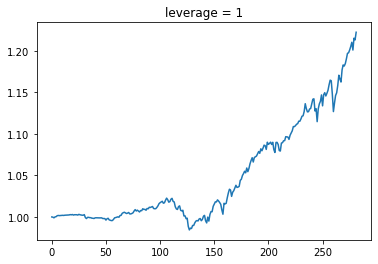

In [61]:
leverage = 1
strategy_returns = leverage * market_timing_returns
plt.plot(np.cumprod(1 + strategy_returns))
plt.title(f'leverage = {leverage}')

In [62]:
cleaned_data['market_timing_returns'] = 0

In [63]:
cleaned_data['market_timing_returns'].iloc[split:] = market_timing_returns.flatten()

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [64]:
tmp = cleaned_data[['excess_returns', 'market_timing_returns']].iloc[split:]
tmp = tmp / tmp.std()

<AxesSubplot:xlabel='yyyymm'>

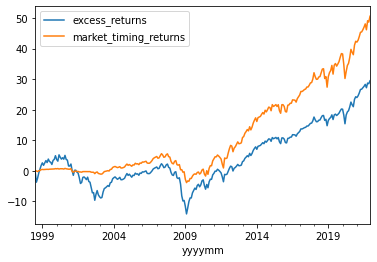

In [65]:
tmp.cumsum().plot()

In [66]:
number_random_features = 1017
omega = np.random.randn(signals.shape[1], number_random_features)

In [67]:
signals.shape

(564, 14)

In [68]:
random_features = np.sin(signals @ omega * 0.0000000000001)
random_features = random_features / random_features.std()

In [69]:
random_features.shape


(564, 1017)

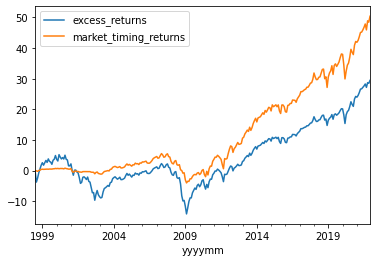

In [71]:
split = int(signals.shape[0] / 2)

labels = cleaned_data.excess_returns.values.reshape(-1, 1)
signals = cleaned_data.iloc[:, :-2].shift(1).fillna(0).values

train_labels = labels[:split]
test_labels = labels[split:]
ridge_penalty = 0.00000001

beta_estimate_using_train_sample = naive_ridge_regression(train_labels, 
                                                          features=random_features[:split, :], 
                                                          penalty=ridge_penalty)

predictions_based_on_train_sample_betas = random_features[split:, :] @ beta_estimate_using_train_sample
market_timing_returns = predictions_based_on_train_sample_betas * test_labels
cleaned_data['market_timing_returns'].iloc[split:] = market_timing_returns.flatten()
tmp = cleaned_data[['excess_returns', 'market_timing_returns']].iloc[split:]
tmp = tmp / tmp.std()
tmp.cumsum().plot()

plt.savefig(os.path.join(data_folder, 'performance_plot.jpeg'))